# Setup

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src')
sys.path.append('src/util')

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pint
import time
import codetimer as ct
import GLE_simulation_v3_numba as gle
import GLE_simulation_v3_nonumba as gle_no
import GLE_simulation_v3
import force_v3 as force

pd.set_option('display.max_rows', 10)
pd.set_option('precision', 9)
np.set_printoptions(edgeitems=5, precision=5)

mpl.rcParams['agg.path.chunksize'] = 10000
sns.set(context="notebook", style="whitegrid", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.axes_style({'xtick.minor.size': 0.5,'ytick.minor.size': 0.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'xtick.minor.size': 0.5, 'ytick.minor.size': 0.5}

---
## Test Langevin Impulse integration

In [29]:
PI = np.pi
kB = 1.3806485e-23
Nrep, Naux, D = 2000, 1, 1

# Physical data for water taken from [Water (data page)](https://en.wikipedia.org/wiki/Water_(data_page))
Te   = 303.15                 # [K] (30 deg C)
eta  = 0.8007e-3              # [Pa*s] = [kg/m/s] (@ 303.15 K)
rhof = 0.9956502e3            # [kg/m^3]          (@ 303.15 K)
rhop = 1.0*rhof               # [kg/m^3]
### Vesicle parameters ###
R = 1.0e-7                    # [m]
m = rhop*(4./3.)*PI*R**3      # [kg]    particle mass 
gam0 = 6*PI*eta*R/m           # [1/s]   collision frequency
tau0 = (m/(3*PI*(R**2)*(eta*rhof)**0.5))**2  # [1/s]   collision frequency
nu1 = 0.25*gam0      # [1/s]

V0  = 1.0           # [J/m] = [N] amplitude of washboard sinusoidal function
L0  = 1.0*R         # spatial period of washboard potential/force
C0  = 0.75          # steepness of washboard potential

In [30]:
### Base units ###
Lc  = R                     # length      [m]
# Lc  = L0                    # length      [m]
Tc  = tau0                  # time        [s]
Ec  = m*(Lc/Tc)**2          # energy      [J]
Tec = Te                    # temperature [K]
### Derived units ###
Vc  = Lc/Tc                 # velocity    [m/s]
Mc  = Ec/Vc**2              # mass        [kg]
Nc  = Mc/Lc**3              # density     [kg/m^3]
Fc  = Ec/Lc                 # force       [N]

dt  = 1.0e-4*Tc     # [s]

In [31]:
print 'mass = {:7.4e} kg'.format(m)
print 'gam0 = {:7.4e} 1/s'.format(gam0)
print 'nu1  = {:7.4e} 1/s'.format(nu1)
print 'V0   = {:7.4e} J/m'.format(V0)
print 'tau0 = {:7.4e} s'.format(tau0)
print 'L0   = {:7.4e} m'.format(L0)
print 'C0   = {:7.4e} J/m'.format(C0)

print '\n'
print 'Lc  = {:7.4e} m'.format(Lc)
print 'Mc  = {:7.4e} kg'.format(Mc)
print 'Tc  = {:7.4e} s'.format(Tc)
print 'Nc  = {:7.4e} kg/m^3'.format(Nc)
print 'Vc  = {:7.4e} m/s'.format(Vc)
print 'Ec  = {:7.4e} kg(m/s)^2'.format(Ec)
print 'Fc  = {:7.4e} kg m/s^2'.format(Fc)
print 'Tec = {:7.4e} K'.format(Tec)
print '\n','dt  = {:7.4e} s'.format(dt)

mass = 4.1706e-18 kg
gam0 = 3.6189e+08 1/s
nu1  = 9.0472e+07 1/s
V0   = 1.0000e+00 J/m
tau0 = 2.4562e-09 s
L0   = 1.0000e-07 m
C0   = 7.5000e-01 J/m


Lc  = 1.0000e-07 m
Mc  = 4.1706e-18 kg
Tc  = 2.4562e-09 s
Nc  = 4.1706e+03 kg/m^3
Vc  = 4.0713e+01 m/s
Ec  = 6.9128e-15 kg(m/s)^2
Fc  = 6.9128e-08 kg m/s^2
Tec = 3.0315e+02 K

dt  = 2.4562e-13 s


---
## Set up `distributed`

If you create an client without providing an address it will start up a local scheduler and worker for you:
```
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client
```

**Notes for remote machines**:
* Make sure that `dask-scheduler` has been run at the cmd line on the machine acting as server.
  * Just running `dask-scheduler` on a local machine is sufficient for a local scheduler
* Make sure that something like `dworker --nprocs 2 --nthreads 1 10.206.30.254:8786` has been run at the cmd line on the target machine.
  * Run `ifconfig | grep inet` at the cmd line of target machine to check its IP address.
```
from dask.distributed import Executor, progress
ex = Executor('10.206.30.254:8786')
print ex
```

#### Example use of `map` and `submit`

```
>>> A = client.map(my_func1, range(10))
>>> B = client.map(my_func2, A)
>>> total = client.submit(my_func3, B)
>>> total.result()
```

#### Test picklability of sim object

```
from cloudpickle import dumps, loads
loads(dumps(sim))
```

---
## Extended Langevin simulation (`sim`)

#### Numba (jit)

In [50]:
sim_numba.close_trj_files()

Closing trajectory files. Data stored in:
	data


In [51]:
sim_numba = gle.GLESimulation(outname='data/ELI_aux_numbatest', method='ELI',
                        Nrep=Nrep, Naux=Naux, D=D, Te=Te, tau0=tau0, L=L0,
                        R=R, rhp=rhop, rhf=rhof, eta=eta,
                        gam0=gam0, nu1=nu1, dt=dt, maxboltz=True, seed=1234567)

# sim.add_force(force.WashboardForce, 'washboard', V0=V0, L0=L0/Lc, C0=0.75)
# sim.add_force(force.ConstantUniformForce, 'noforce', C0=0.0)
# sim.add_force(force.LinearUniformForce, 'harmonic', C1=-1.0, C0=0.0)
sim_numba.set_integrator('ELI')

In [52]:
with ct.Timer(unit='secs') as t:
    sim_numba.run(nsteps=50000, tmpsize=100, ntout=500, printout=5000)
print "– elapsed time: {:.1f} s".format(t.secs)

Closing trajectory files. Data stored in:
	data
– elapsed time: 10.8 s


#### Numba (vectorize)

In [15]:
sim_numbav.close_trj_files()

Closing trajectory files. Data stored in:
	data


In [ ]:
sim_numbav = gle.GLESimulation(outname='data/ELI_aux_numbavtest', method='ELI',
                        Nrep=Nrep, Naux=Naux, D=D, Te=Te, tau0=tau0, L=L0,
                        R=R, rhp=rhop, rhf=rhof, eta=eta,
                        gam0=gam0, nu1=nu1, dt=dt, maxboltz=True, seed=1234567)

# sim.add_force(force.WashboardForce, 'washboard', V0=V0, L0=L0/Lc, C0=0.75)
# sim.add_force(force.ConstantUniformForce, 'noforce', C0=0.0)
# sim.add_force(force.LinearUniformForce, 'harmonic', C1=-1.0, C0=0.0)
sim_numbav.set_integrator('ELI')

In [ ]:
with ct.Timer(unit='secs') as t:
    sim_numbav.run(nsteps=50000, tmpsize=100, ntout=500, printout=5000)
print "– elapsed time: {:.1f} s".format(t.secs)

#### No Numba

In [56]:
sim_nonumba.close_trj_files()

Closing trajectory files. Data stored in:
	data


In [57]:
sim_nonumba = gle_no.GLESimulation(outname='data/ELI_aux_nonumbatest', method='ELI',
                        Nrep=Nrep, Naux=Naux, D=D, Te=Te, tau0=tau0, L=L0,
                        R=R, rhp=rhop, rhf=rhof, eta=eta,
                        gam0=gam0, nu1=nu1, dt=dt, maxboltz=True, seed=1234567)

# sim.add_force(force.WashboardForce, 'washboard', V0=V0, L0=L0/Lc, C0=0.75)
# sim.add_force(force.ConstantUniformForce, 'noforce', C0=0.0)
# sim.add_force(force.LinearUniformForce, 'harmonic', C1=-1.0, C0=0.0)
sim_nonumba.set_integrator('ELI')

In [58]:
with ct.Timer(unit='secs') as t:
    sim_nonumba.run(nsteps=50000, tmpsize=100, ntout=500, printout=5000)
print "– elapsed time: {:.1f} s".format(t.secs)

Closing trajectory files. Data stored in:
	data
– elapsed time: 4.8 s


---

In [14]:
sim.close_trj_files()

Closing trajectory files. Data stored in:
	data


---
## Regular Langevin simulation (`sim_le`)

In [69]:
sim_le = gle.GLESimulation(outname='data/ELI_le', method='ELI',
                        Nrep=Nrep, Naux=Naux, D=D, Te=Te, tau0=tau0, L=L0,
                        R=R, rhp=rhop, rhf=rhof, eta=eta,
                        gam0=gam0, nu1=0, dt=dt, maxboltz=True, seed=1234567)

# sim_le.add_force(force.WashboardForce, 'washboard', V0=V0, L0=L0/Lc, C0=0.75)
sim_le.add_force(force.ConstantUniformForce, 'noforce', C0=0.0)
# sim_le.add_force(force.LinearUniformForce, 'harmonic', C1=-1.0, C0=0.0)
sim_le.set_integrator('ELI')

Registered force "noforce" to the system.
Setting parameters for ELI integrator.
sqrt2kTim: 0.000898491433092
the0:      0.999911115062
alp0:      0.0094276714051
sig0:      8.47068199149e-06
the1:      1.0
alp1:      0.0
sig1:      0.0


In [ ]:
with ct.Timer(unit='secs') as t:
    sim_le.run(nsteps=10000000, tmpsize=400000, ntout=25, printout=1000)
print "– elapsed time: {:.1f} s".format(t.secs)

---

---
## Plotting

### Histogram of thermal-drag force ratio

**Note**: the thermal and drag forces are computed as averages over the simulation ensemble and all timesteps. Thus, the histogram should be symmetric if the particles start off in equilibrium (distributed according to Maxwell-Boltzmann) and asymmetric for other initial conditions (like zero velocity).

In [25]:
meff = (rhop+0.5*rhof)/rhof

MSFther = ((sim.thermal_forces.iloc[:,:])**2).mean(axis=1)
MSV = (sim.velocities.iloc[:,:]**2).mean(axis=1)
MSFdrag = 2*gam0*Tc/(dt/Tc)*meff**2*MSV
MSFdrag_MSFther = MSFdrag.iloc[1:]/MSFther.iloc[1:]

MSFther_tot = ((sim.thermal_forces.iloc[:,:])**2).mean().mean()
MSV_tot = (sim.velocities.iloc[:,:]**2).mean().mean()
MSFdrag_tot = 2*gam0*Tc/(dt/Tc)*meff**2*MSV_tot

figscale, aspect = 1.5, 0.75
figsize = figscale * plt.figaspect(float(aspect))
plt.figure(figsize=figsize)
MSFdrag_MSFther.hist(bins=30, density=True)
plt.xlabel(r'$\frac{2m^2\gamma}{\Delta t} \frac{\left\langle\Delta v^2\right\rangle}{\left\langle\Delta F_{th}^2\right\rangle}$')
plt.ylabel(r'Probability density')

print 'Average (avg2) mean-square drag force:    {:8.6f} ({:8.6f})'.format(MSFdrag.mean(), MSFdrag_tot)
print 'Average (avg2) mean-square thermal force: {:8.6f} ({:8.6f})'.format(MSFther.mean(), MSFther_tot)

Average (avg2) mean-square drag force:    0.015813 (0.015813)
Average (avg2) mean-square thermal force: 0.016134 (0.016134)


Average (avg2) mean-square drag force:    0.016158 (0.016158)
Average (avg2) mean-square thermal force: 0.016154 (0.016154)


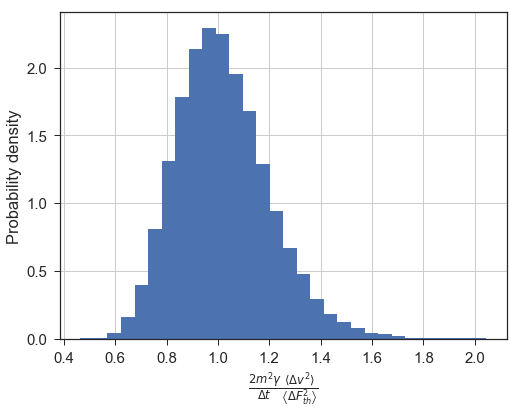

In [34]:
meff = (rhop+0.5*rhof)/rhof

MSFther = ((sim.thermal_forces.iloc[:,:])**2).mean(axis=1)
MSV = (sim.velocities.iloc[:,:]**2).mean(axis=1)
MSFdrag = 2*gam0*Tc/(dt/Tc)*meff**2*MSV
MSFdrag_MSFther = MSFdrag.iloc[1:]/MSFther.iloc[1:]

MSFther_tot = ((sim.thermal_forces.iloc[:,:])**2).mean().mean()
MSV_tot = (sim.velocities.iloc[:,:]**2).mean().mean()
MSFdrag_tot = 2*gam0*Tc/(dt/Tc)*meff**2*MSV_tot

figscale, aspect = 1.5, 0.75
figsize = figscale * plt.figaspect(float(aspect))
plt.figure(figsize=figsize)
MSFdrag_MSFther.hist(bins=30, density=True)
plt.xlabel(r'$\frac{2m^2\gamma}{\Delta t} \frac{\left\langle\Delta v^2\right\rangle}{\left\langle\Delta F_{th}^2\right\rangle}$')
plt.ylabel(r'Probability density')

print 'Average (avg2) mean-square drag force:    {:8.6f} ({:8.6f})'.format(MSFdrag.mean(), MSFdrag_tot)
print 'Average (avg2) mean-square thermal force: {:8.6f} ({:8.6f})'.format(MSFther.mean(), MSFther_tot)

#### $\mathcal{P}\left(\frac{2m^2\gamma\left\langle\Delta v^2\right\rangle/\Delta t}{\left\langle\Delta F_{th}^2\right\rangle}\right)$ for GLE (with single aux variable)

Average (avg2) mean-square drag force:    0.015559 (0.015559)
Average (avg2) mean-square thermal force: 0.016146 (0.016146)


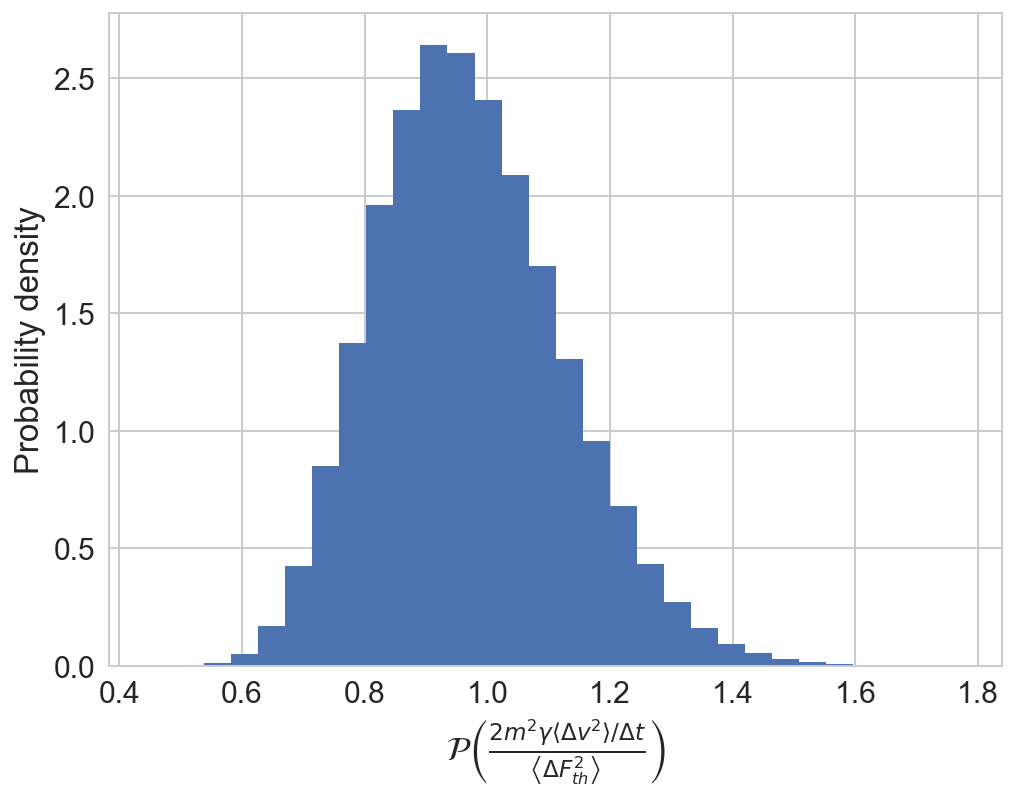

In [15]:
%config InlineBackend.figure_format = 'retina'

meff = (rhop+0.5*rhof)/rhof

MSFther = ((sim.thermal_forces.iloc[:,:])**2).mean(axis=1)
MSV = (sim.velocities.iloc[:,:]**2).mean(axis=1)
MSFdrag = 2*gam0*Tc/(dt/Tc)*meff**2*MSV
MSFdrag_MSFther = MSFdrag.iloc[1:]/MSFther.iloc[1:]

MSFther_tot = ((sim.thermal_forces.iloc[:,:])**2).mean().mean()
MSV_tot = (sim.velocities.iloc[:,:]**2).mean().mean()
MSFdrag_tot = 2*gam0*Tc/(dt/Tc)*meff**2*MSV_tot

figscale, aspect = 1.5, 0.75
figsize = figscale * plt.figaspect(float(aspect))
plt.figure(figsize=figsize)
MSFdrag_MSFther.hist(bins=30, density=True)
plt.xlabel(r'$\mathcal{P}\left(\frac{2m^2\gamma\left\langle\Delta v^2\right\rangle/\Delta t}{\left\langle\Delta F_{th}^2\right\rangle}\right)$')
plt.ylabel(r'Probability density')

print 'Average (avg2) mean-square drag force:    {:8.6f} ({:8.6f})'.format(MSFdrag.mean(), MSFdrag_tot)
print 'Average (avg2) mean-square thermal force: {:8.6f} ({:8.6f})'.format(MSFther.mean(), MSFther_tot)

Average (avg2) mean-square drag force:    0.016238 (0.016238)
Average (avg2) mean-square thermal force: 0.016146 (0.016146)


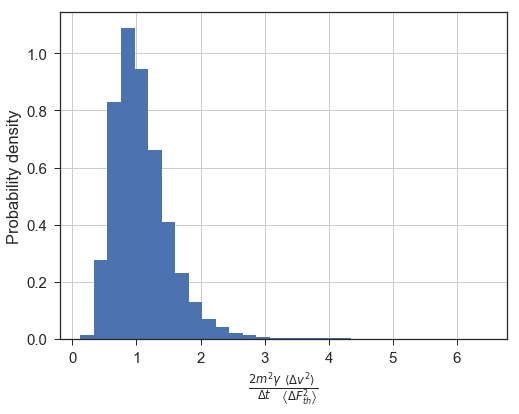

In [62]:
meff = (rhop+0.5*rhof)/rhof

MSFther = ((sim.thermal_forces.iloc[:,:])**2).mean(axis=1)
MSV = (sim.velocities.iloc[:,:]**2).mean(axis=1)
MSFdrag = 2*gam0*Tc/(dt/Tc)*meff**2*MSV
MSFdrag_MSFther = MSFdrag.iloc[1:]/MSFther.iloc[1:]

MSFther_tot = ((sim.thermal_forces.iloc[:,:])**2).mean().mean()
MSV_tot = (sim.velocities.iloc[:,:]**2).mean().mean()
MSFdrag_tot = 2*gam0*Tc/(dt/Tc)*meff**2*MSV_tot

figscale, aspect = 1.5, 0.75
figsize = figscale * plt.figaspect(float(aspect))
plt.figure(figsize=figsize)
MSFdrag_MSFther.hist(bins=30, density=True)
plt.xlabel(r'$\frac{2m^2\gamma}{\Delta t} \frac{\left\langle\Delta v^2\right\rangle}{\left\langle\Delta F_{th}^2\right\rangle}$')
plt.ylabel(r'Probability density')

print 'Average (avg2) mean-square drag force:    {:8.6f} ({:8.6f})'.format(MSFdrag.mean(), MSFdrag_tot)
print 'Average (avg2) mean-square thermal force: {:8.6f} ({:8.6f})'.format(MSFther.mean(), MSFther_tot)

Average (avg2) mean-square drag force:    0.015559 (0.015559)
Average (avg2) mean-square thermal force: 0.016146 (0.016146)


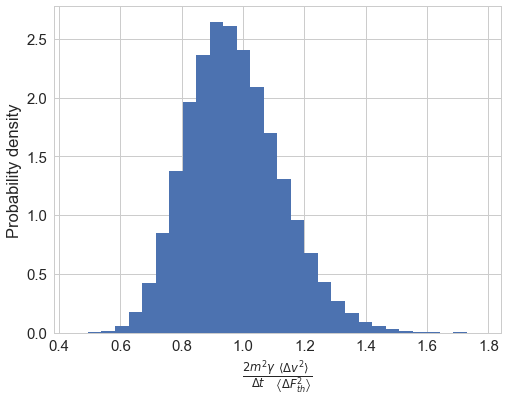

In [7]:
meff = (rhop+0.5*rhof)/rhof

MSFther = ((sim.thermal_forces.iloc[:,:])**2).mean(axis=1)
MSV = (sim.velocities.iloc[:,:]**2).mean(axis=1)
MSFdrag = 2*gam0*Tc/(dt/Tc)*meff**2*MSV
MSFdrag_MSFther = MSFdrag.iloc[1:]/MSFther.iloc[1:]

MSFther_tot = ((sim.thermal_forces.iloc[:,:])**2).mean().mean()
MSV_tot = (sim.velocities.iloc[:,:]**2).mean().mean()
MSFdrag_tot = 2*gam0*Tc/(dt/Tc)*meff**2*MSV_tot

figscale, aspect = 1.5, 0.75
figsize = figscale * plt.figaspect(float(aspect))
plt.figure(figsize=figsize)
MSFdrag_MSFther.hist(bins=30, density=True)
plt.xlabel(r'$\frac{2m^2\gamma}{\Delta t} \frac{\left\langle\Delta v^2\right\rangle}{\left\langle\Delta F_{th}^2\right\rangle}$')
plt.ylabel(r'Probability density')

print 'Average (avg2) mean-square drag force:    {:8.6f} ({:8.6f})'.format(MSFdrag.mean(), MSFdrag_tot)
print 'Average (avg2) mean-square thermal force: {:8.6f} ({:8.6f})'.format(MSFther.mean(), MSFther_tot)

#### $\mathcal{P}\left(\frac{2m^2\gamma\left\langle\Delta v^2\right\rangle/\Delta t}{\left\langle\Delta F_{th}^2\right\rangle}\right)$ for standard LE

In [71]:
meff = (rhop+0.5*rhof)/rhof

MSFther = ((sim_le.thermal_forces.iloc[:,:])**2).mean(axis=1)
MSV = (sim_le.velocities.iloc[:,:]**2).mean(axis=1)
MSFdrag = 2*gam0*Tc/(dt/Tc)*meff**2*MSV
MSFdrag_MSFther = MSFdrag.iloc[1:]/MSFther.iloc[1:]

MSFther_tot = ((sim_le.thermal_forces.iloc[:,:])**2).mean().mean()
MSV_tot = (sim_le.velocities.iloc[:,:]**2).mean().mean()
MSFdrag_tot = 2*gam0*Tc/(dt/Tc)*meff**2*MSV_tot

figscale, aspect = 1.5, 0.75
figsize = figscale * plt.figaspect(float(aspect))
plt.figure(figsize=figsize)
MSFdrag_MSFther.hist(bins=30, density=True)
plt.xlabel(r'$\frac{2m^2\gamma}{\Delta t} \frac{\left\langle\Delta v^2\right\rangle}{\left\langle\Delta F_{th}^2\right\rangle}$')
plt.ylabel(r'Probability density')

print 'Average (avg2) mean-square drag force:    {:8.6f} ({:8.6f})'.format(MSFdrag.mean(), MSFdrag_tot)
print 'Average (avg2) mean-square thermal force: {:8.6f} ({:8.6f})'.format(MSFther.mean(), MSFther_tot)

Average (avg2) mean-square drag force:    0.016028 (0.016028)
Average (avg2) mean-square thermal force: 0.016146 (0.016146)


### 2D real-space plot

In [ ]:
stepi, stepD, stride = 0, 100000, 100
stepf = stepi + stepD

plt.clf()
lims = 3.2e-2*np.vstack((-np.ones(3), np.ones(3))).T
ax = None
for i in xrange(Nrep):
    ax = sim.quick_plot_2D(start=stepi, stop=stepf, step=stride, n=i,
                               lims=lims, figscale=1.5, aspect=1.0, ax=ax)

### Mean-squared distance vs time

**Note**: the early-time scaling of the MSD will depend on the initial velocity distribution of the simulation ensemble. For example:
* The MSD should grow proportionally to $t^2$ (ballistic) for Maxwell-Boltzmann distributed velocities.
* The MSD should grow proportionally to $t^3$ (superballistic) when the velocities are initialized to zero.

Once the long-time (diffusive) regime is reached, the scaling should always be *linear* in $t$.

In [35]:
t = sim.times.values
Xtothe2 = (sim.positions.iloc[:,:]**2).sum(axis=1)/Nrep

In [29]:
figscale, aspect = 1.5, 0.75
figsize = figscale * plt.figaspect(float(aspect))
plt.figure(figsize=figsize)
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle \Delta x^2\right\rangle$')
plt.loglog(t[1:], Xtothe2.iloc[1:], label='simulations')
plt.loglog(t[1:], (1e-1*t[1:])**3, ls=':', label='$t^3$')
plt.loglog(t[1:], (1e-3*t[1:])**2, ls='--', label='$t^2$')
plt.loglog(t[1:], 3.2e-6*t[1:], ls='--', label='$t$')
# plt.loglog(t, (1e6*t)w**1.5, label='$t^{3/2}$')
plt.legend()

In [41]:
t = sim.times.values
Xtothe2 = (sim.positions.iloc[:,:]**2).mean(axis=1)  # average over the ensemble

In [42]:
figscale, aspect = 1.5, 0.75
figsize = figscale * plt.figaspect(float(aspect))
plt.figure(figsize=figsize)
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle \Delta x^2\right\rangle$')
plt.loglog(t[1:], Xtothe2.iloc[1:], label='simulations')
plt.loglog(t[1:], (1e-1*t[1:])**3, ls=':', label='$t^3$')
plt.loglog(t[1:], (1e-3*t[1:])**2, ls='--', label='$t^2$')
plt.loglog(t[1:], 3.2e-6*t[1:], ls='--', label='$t$')
# plt.loglog(t, (1e6*t)w**1.5, label='$t^{3/2}$')
plt.legend()

In [100]:
t = sim.times.values
Xtothe2 = (sim.positions.iloc[:,:]**2).mean(axis=1)  # average over the ensemble

figscale, aspect = 1.5, 0.75
figsize = figscale * plt.figaspect(float(aspect))
plt.figure(figsize=figsize)
plt.title('MSD scaling: GLE (single auxiliary variable)')
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle \Delta x^2\right\rangle$')
plt.loglog(t[1:], Xtothe2.iloc[1:], label='simulation ensemble')

t_asymp = np.logspace(np.log10(t[1]), np.log10(t[-1]), 100)
plt.loglog(t_asymp, 1.0e-6*t_asymp**2, ls='--', label='$t^2$ (ballistic)')
plt.loglog(t_asymp, 1.5e-6*t_asymp, ls='--', label='$t$ (diffusive)')
plt.legend()
plt.savefig('data/figs/MSD_GLE_1aux_2600ns_run000.pdf')

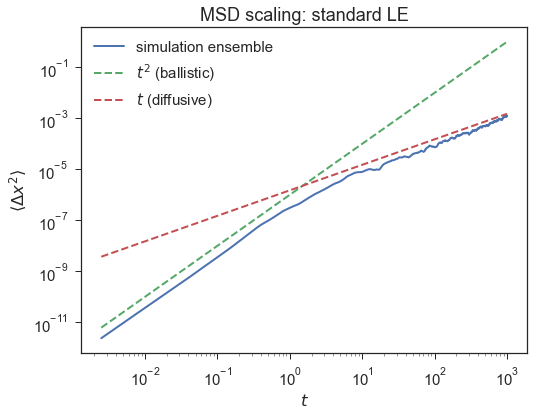

In [101]:
t = sim_le.times.values
Xtothe2 = (sim_le.positions.iloc[:,:]**2).mean(axis=1)  # average over the ensemble

figscale, aspect = 1.5, 0.75
figsize = figscale * plt.figaspect(float(aspect))
plt.figure(figsize=figsize)
plt.title('MSD scaling: standard LE')
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle \Delta x^2\right\rangle$')
plt.loglog(t[1:], Xtothe2.iloc[1:], label='simulation ensemble')

t_asymp = np.logspace(np.log10(t[1]), np.log10(t[-1]), 100)
plt.loglog(t_asymp, 1.0e-6*t_asymp**2, ls='--', label='$t^2$ (ballistic)')
plt.loglog(t_asymp, 1.5e-6*t_asymp, ls='--', label='$t$ (diffusive)')
plt.legend()
plt.savefig('data/figs/MSD_LE_2600ns_run000.pdf')

---

### Mean-squared velocity vs time

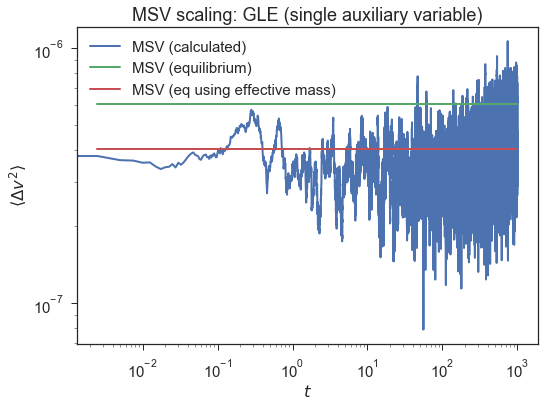

In [112]:
t = sim.velocities.index.values
MSV = (sim.velocities.iloc[:,:]**2).mean(axis=1)

t_asymp = np.logspace(np.log10(t[1]), np.log10(t[-1]), 100)
MSV_eq = kB*Te/m *(Mc/Ec) * np.ones_like(t_asymp)

figscale, aspect = 1.5, 0.75
figsize = figscale * plt.figaspect(float(aspect))
plt.figure(figsize=figsize)
plt.title('MSV scaling: GLE (single auxiliary variable)')
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle \Delta v^2\right\rangle$')
plt.loglog(t, MSV, label='MSV (calculated)')
plt.loglog(t_asymp, MSV_eq, label='MSV (equilibrium)')
plt.loglog(t_asymp, MSV_eq/1.5, label='MSV (eq using effective mass)')
plt.legend()
plt.tight_layout()
plt.savefig('data/figs/MSV_GLE_1aux_2600ns_run000.pdf')

In [8]:
t = sim.velocities.index.values
MSV = (sim.velocities.iloc[:,:]**2).mean(axis=1)

t_asymp = np.logspace(np.log10(t[1]), np.log10(t[-1]), 100)
MSV_eq = kB*Te/m *(Mc/Ec) * np.ones_like(t_asymp)

figscale, aspect = 1.5, 0.75
figsize = figscale * plt.figaspect(float(aspect))
plt.figure(figsize=figsize)
plt.title('MSV scaling: GLE (single auxiliary variable)')
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle \Delta v^2\right\rangle$')
plt.loglog(t, MSV, label='MSV (calculated)')
plt.loglog(t_asymp, MSV_eq, label='MSV (equilibrium)')
plt.loglog(t_asymp, MSV_eq/1.5, label='MSV (eq using effective mass)')
plt.legend()
plt.tight_layout()
plt.savefig('data/figs/MSV_GLE_1aux_2600ns_run000.pdf')

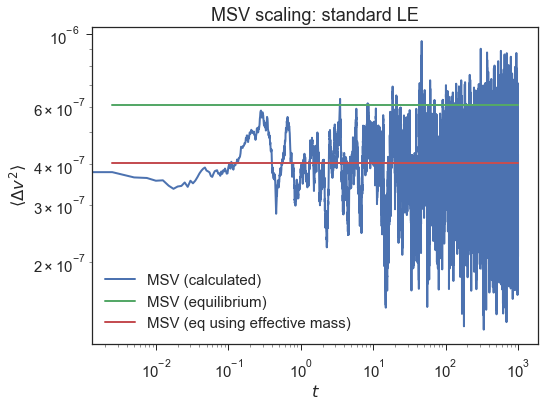

In [111]:
t = sim_le.velocities.index.values
MSV = (sim_le.velocities.iloc[:,:]**2).mean(axis=1)

t_asymp = np.logspace(np.log10(t[1]), np.log10(t[-1]), 100)
MSV_eq = kB*Te/m *(Mc/Ec) * np.ones_like(t_asymp)

figscale, aspect = 1.5, 0.75
figsize = figscale * plt.figaspect(float(aspect))
plt.figure(figsize=figsize)
plt.title('MSV scaling: standard LE')
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle \Delta v^2\right\rangle$')
plt.loglog(t, MSV, label='MSV (calculated)')
plt.loglog(t_asymp, MSV_eq, label='MSV (equilibrium)')
plt.loglog(t_asymp, MSV_eq/1.5, label='MSV (eq using effective mass)')
plt.legend()
plt.tight_layout()
plt.savefig('data/figs/MSV_LE_2600ns_run000.pdf')

### Velocity distribution at various times

In [9]:
# Can also think about writing a function or something that converts easily
#   b/w integer indexing of trajectories and the simulation time (either
#   nondimensional time or in, say, nanoseconds?)

def velocity_hist(velocities, tidx, figname, figdir='data/figs', append_time=True, **kwargs):
    figscale, aspect = 1.5, 0.75
    figsize = figscale * plt.figaspect(float(aspect))
    plt.figure(figsize=figsize)
    plt.title(r'Velocity distribution')
    plt.xlabel(r'$v$')
    plt.ylabel(r'$\mathcal{P}(v)$')
    t_eql_str = '$t = {}$'.format(tidx)
    
    velocities.iloc[tidx,:].hist(label=r''+t_eql_str, **kwargs)
    plt.legend()
    plt.tight_layout()
    
    if append_time:
        figname = '{}_tidx={}'.format(figname, tidx)
    plt.savefig('{}/{}.pdf'.format(figdir, figname))

#### $\mathcal{P}(v,t)$ for GLE (with single aux variable)

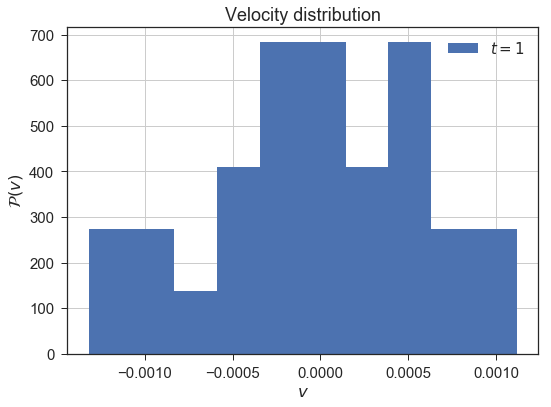

In [130]:
velocity_hist(sim.velocities, 1, 'PofV_GLE_1aux_2600ns', bins=10, density=True)

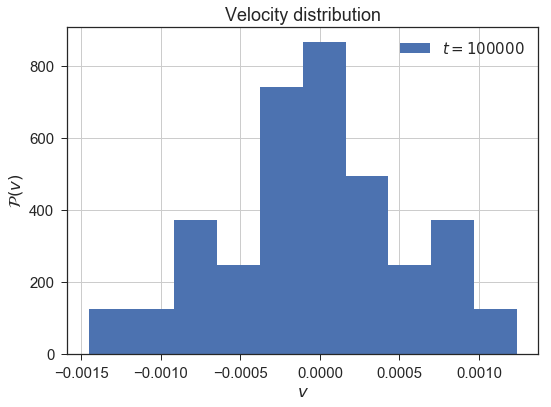

In [131]:
velocity_hist(sim.velocities, 100000, 'PofV_GLE_1aux_2600ns', bins=10, density=True)

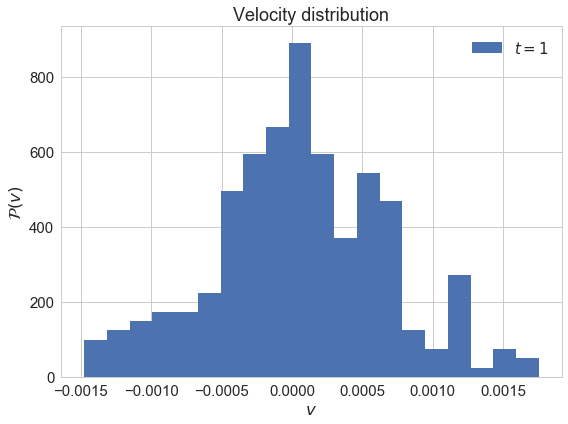

In [14]:
velocity_hist(sim.velocities, 1, 'PofV_GLE_1aux_2600ns', bins=20, density=True)
velocity_hist(sim.velocities, 25000, 'PofV_GLE_1aux_2600ns', bins=20, density=True)

#### $\mathcal{P}(v,t)$ for standard LE

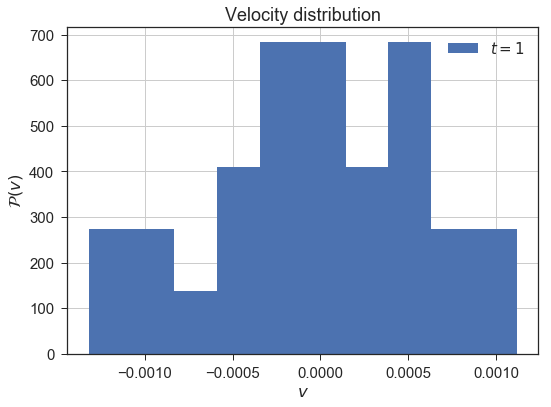

In [132]:
velocity_hist(sim_le.velocities, 1, 'PofV_LE_2600ns', bins=10, density=True)

In [133]:
velocity_hist(sim_le.velocities, 100000, 'PofV_LE_2600ns', bins=10, density=True)

#### Testing

In [151]:
t = sim.velocities.index.values
MSV = (sim.velocities.iloc[:,:]**2).mean(axis=1)

t_asymp = np.logspace(np.log10(t[1]), np.log10(t[-1]), 100)
MSV_eq = kB*Te/m *(Mc/Ec) * np.ones_like(t)

In [195]:
t = sim.times.values
MSD = (sim.positions.iloc[:,:]**2).mean(axis=1)
MSV2 = (MSD - np.roll(MSD, 1)) / (dt/Tc)
MSV3 = sim.positions.iloc[:,:]

In [206]:
plt.figure(figsize=figsize)
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle \Delta v^2(t)\right\rangle$')
plt.loglog(t, MSV, label=r'$\left\langle \Delta v^2(t)\right\rangle$ (calculated)')
plt.loglog(t[1:], MSD.iloc[1:]/t[1:], label=r'$\left\langle \Delta x^2(t)\right\rangle / t$')
plt.loglog(t[1:-1], MSV2.iloc[1:-1], label=r'$\left\langle (\Delta x(t+\Delta t) -\Delta x(t))/\Delta t\right\rangle$')
plt.loglog(t, MSV_eq, label=r'$\left\langle \Delta v^2\right\rangle_\mathrm{eq}$')
plt.loglog(t, MSV_eq/1.5, label=r'$\left\langle \Delta v^2\right\rangle_\mathrm{eq}$ (using effective mass)')
plt.legend()

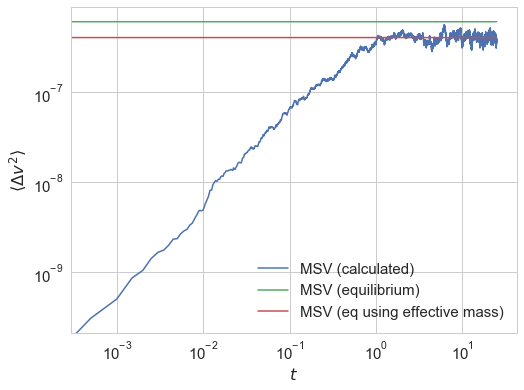

In [129]:
plt.figure(figsize=figsize)
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle \Delta v^2\right\rangle$')
plt.loglog(t, MSV, label='MSV (calculated)')
plt.loglog(t, MSV_eq, label='MSV (equilibrium)')
plt.loglog(t, MSV_eq/1.5, label='MSV (eq using effective mass)')
plt.legend()

In [112]:
plt.figure(figsize=figsize)
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle \Delta v^2\right\rangle$')
plt.loglog(t, MSV, label='MSV (calculated)')
plt.loglog(t, MSV_eq, label='MSV (equilibrium)')
plt.loglog(t, MSV_eq/1.5, label='MSV (eq using effective mass)')
plt.legend()

In [62]:
plt.figure(figsize=figsize)
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle \Delta v^2\right\rangle$')
plt.loglog(t, Vtothe2, label='simulations')
plt.legend()

### Position autocorrelation

### Velocity autocorrelation

In [23]:
import multiprocessing as mp
from pandas.plotting import autocorrelation_plot

sys.path.append('src/util/backup_and_examples')
import parallelizer_v3 as pv3

In [21]:
def worker(series):
    return autocorrelation_plot(series).lines[5].get_ydata()

In [24]:
df_V_list = [sim.velocities['Run {}'.format(i+1)]['vx'] for i in xrange(Nrep)]

In [25]:
par_v3_map_async = pv3.Parallelizer(worker, df_V_list[:5], data_size=5)

In [ ]:
par_v3_map_async.run(N_WORKERS=4, TASK_SIZE=1, method='map_async')
pv3_map_async = par_v3_map_async.results


Progress:
[--------------------------------------------------

#### Extract `xy` data from the autocorrelation plot

In [121]:
vacf_line = vacf_plt.lines[5]  # the last element is the one containing the autocorr data
vacf_yvals = vacf_line.get_ydata()

array([[1.00000e+00, 9.99887e-01],
       [2.00000e+00, 9.99774e-01],
       [3.00000e+00, 9.99661e-01],
       [4.00000e+00, 9.99547e-01],
       [5.00000e+00, 9.99433e-01],
       ...,
       [1.99996e+05, 1.00741e-05],
       [1.99997e+05, 7.56945e-06],
       [1.99998e+05, 5.09058e-06],
       [1.99999e+05, 2.55782e-06],
       [2.00000e+05, 0.00000e+00]])

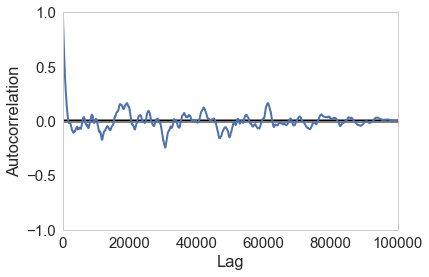

In [91]:
autocorrelation_plot(V1)

In [80]:
def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a DataFrame."""

    return (df.rolling(window=window).corr(df.shift(lag))).dropna() # could .dropna() here

In [82]:
df_rolling_autocorr(df_V1, window=21).head()

Velocities           vx
0.021       0.972855158
0.022       0.966399761
0.023       0.965188387
0.024       0.960385653
0.025       0.957146179

### Speed distribution ($V^2$)

In [109]:
Vtothe2.plot.hist(bins=100)

In [65]:
Vtothe2.plot.hist(bins=100)

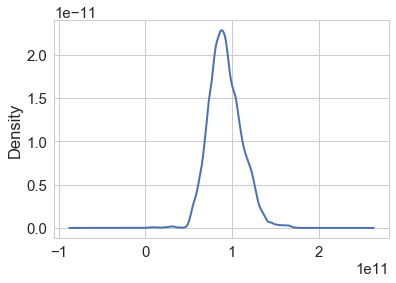

In [71]:
Vtothe2.plot.kde()

---

---

---

In [39]:
plt.close('all')
plt.clf()
tlims = [0, 100000]
xlims = np.array([1.0e-6, 1e2])
stride = 1
ax = None
for i in xrange(Nrep):
    ax = sim.quick_plot_SD(xlims=xlims, tlims=tlims, step=stride, i=i,
                               logscale=True, figscale=1.0, aspect=0.75, ax=ax)

start, stop = tlims[0], tlims[1]
t = (dt/Tc) * np.arange(start, stop, stride)
ax.loglog(t, t**2, label=r'$t^2$')
ax.loglog(t, t**1.5, label=r'$t^{3/2}$')
ax.legend()

In [44]:
stepi, stepD, stride = 0, 1000000, 1000
stepf = stepi + stepD

plt.clf()
lims = 2.5e4*np.vstack((-np.ones(3), np.ones(3))).T
ax = None
for i in xrange(Nrep):
    ax = sim.quick_plot_2D(start=stepi, stop=stepf, step=stride, n=i,
                               lims=lims, figscale=1.5, aspect=0.75, ax=ax)

In [55]:
stepi, stepD, stride = 0, 1000000, 1000
stepf = stepi + stepD

plt.clf()
lims = 2.5e1*np.vstack((-np.ones(3), np.ones(3))).T
ax = None
for i in xrange(Nrep):
    ax = sim.quick_plot_2D(start=stepi, stop=stepf, step=stride, n=i,
                               lims=lims, figscale=1.5, aspect=0.75, ax=ax)

In [25]:
sim.positions

x 1        y 1        x 2        y 2        x 3        y 3  \
1.0        0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00   
2.0       -6.035e-07 -2.776e-06 -1.894e-06  1.114e-06  3.929e-06 -2.992e-07   
3.0       -1.102e-06 -8.650e-06 -4.758e-06  4.362e-06  1.174e-05 -4.829e-06   
4.0       -3.676e-06 -1.454e-05 -8.123e-06  1.238e-05  1.882e-05 -1.276e-05   
5.0       -8.527e-06 -1.973e-05 -1.424e-05  1.911e-05  2.631e-05 -1.639e-05   
6.0       -1.532e-05 -2.050e-05 -2.056e-05  2.034e-05  3.766e-05 -1.644e-05   
7.0       -2.452e-05 -1.993e-05 -2.570e-05  2.180e-05  4.818e-05 -1.605e-05   
8.0       -3.475e-05 -2.083e-05 -2.910e-05  2.513e-05  5.580e-05 -1.454e-05   
9.0       -4.554e-05 -2.433e-05 -2.952e-05  2.948e-05  6.442e-05 -1.259e-05   
10.0      -5.661e-05 -3.126e-05 -2.725e-05  3.048e-05  7.262e-05 -1.289e-05   
11.0      -7.174e-05 -3.658e-05 -2.327e-05  2.664e-05  8.152e-05 -1.691e-05   
12.0      -9.177e-05 -3.876e-05 -1.560e-05  1.985e-05  9.398e-05 -2.526e-05   
13.0      -1.115e-04 -3.941e-05 -7.494e-06  1.337e-05  1.050e-04 -3.749e-05   
14.0      -1.298e-04 -3.919e-05 -2.949e-07  1.008e-05  1.129e-04 -5.191e-05   
15.0      -1.472e-04 -3.886e-05  8.577e-06  1.071e-05  1.210e-04 -7.201e-05   
...              ...        ...        ...        ...        ...        ...   
999986.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
999987.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
999988.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
999989.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
999990.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
999991.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
999992.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
999993.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
999994.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
999995.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
999996.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
999997.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
999998.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
999999.0  -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   
1000000.0 -1.115e+03  2.078e+03  1.761e+03 -2.015e+03  3.190e+03 -1.596e+03   

                 x 4        y 4        x 5        y 5        x 6        y 6  \
1.0        0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00   
2.0        2.503e-06 -1.334e-06  2.402e-06 -1.537e-06 -1.485e-06  2.627e-06   
3.0        6.606e-06 -2.004e-06  8.022e-06 -5.928e-06 -2.352e-06  6.984e-06   
4.0        9.255e-06 -7.876e-08  1.204e-05 -1.323e-05 -5.128e-06  1.083e-05   
5.0        1.209e-05  4.348e-06  1.383e-05 -2.287e-05 -1.227e-05  1.288e-05   
6.0        1.788e-05  1.289e-05  1.746e-05 -3.450e-05 -1.843e-05  1.187e-05   
7.0        2.537e-05  2.519e-05  2.573e-05 -4.718e-05 -2.442e-05  8.880e-06   
8.0        2.935e-05  4.101e-05  3.629e-05 -5.836e-05 -3.102e-05  3.758e-06   
9.0        2.874e-05  5.841e-05  4.622e-05 -6.663e-05 -3.667e-05 -1.725e-06   
10.0       2.892e-05  7.572e-05  5.571e-05 -7.760e-05 -4.574e-05 -2.545e-06   
11.0       3.257e-05  9.408e-05  6.544e-05 -9.103e-05 -5.908e-05  2.508e-06   
12.0       4.157e-05  1.112e-04  7.629e-05 -1.042e-04 -7.358e-05  9.880e-06   
13.0       5.551e-05  1.268e-04  8.972e-05 -1.151e-04 -8.760e-05  1.979e-05   
14.0       6.865e-05  1.432e-04  1.053e-04 -1.200e-04 -9.964e-05  2.954e-05   
15.0       7.870e-05  1.601e-04  1.224e-04 -1.180e-04 -1.109e-04  3.547e-05   
...              ...        ...        ...        ...        ...        ...   
999986.0   2.897e+03  1.871e+03 -2.372e+03  7.411e+02 -9.121e+02  6.810e+02   
999987.0   2.897e+03  1.871e+03 -2.372e+03  7.411e+02 -9.121e+02  

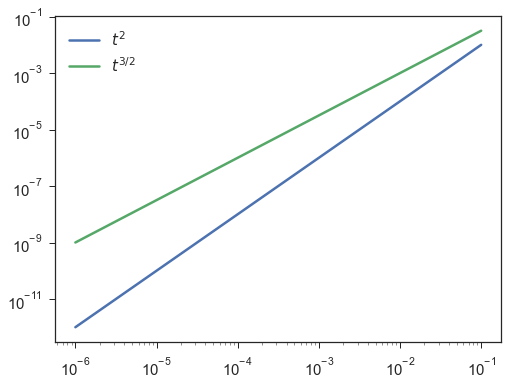

In [55]:
figsize = 1.5 * plt.figaspect(float(0.75))
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

tlims = np.array([1.0, 100000.0])
t = (dt/Tc)*np.arange(tlims[0], tlims[1], 1)
ax.loglog(t, t**2, label=r'$t^2$')
ax.loglog(t, t**1.5, label=r'$t^{3/2}$')
ax.legend()

---

---

In [34]:
def print_params(**kwargs):
    
    print 'mass = {:7.4e} kg'.format(m)
    print 'gam0 = {:7.4e} 1/s'.format(gam0)
    print 'nu1  = {:7.4e} 1/s'.format(nu1)
    print 'V0   = {:7.4e} J/m'.format(V0)
    print 'L0   = {:7.4e} m'.format(L0)
    print 'C0   = {:7.4e} J/m'.format(C0)
    
    print '\n'
    print 'Lc  = {:7.4e} m'.format(Lc)
    print 'Mc  = {:7.4e} kg'.format(Mc)
    print 'Tc  = {:7.4e} s'.format(Tc)
    print 'Nc  = {:7.4e} kg/m^3'.format(Nc)
    print 'Vc  = {:7.4e} m/s'.format(Vc)
    print 'Ec  = {:7.4e} kg(m/s)^2'.format(Ec)
    print 'Fc  = {:7.4e} kg m/s^2'.format(Fc)
    print 'Tec = {:7.4e} K'.format(Tec)
    print '\n','dt  = {:7.4e} s'.format(dt)

---

In [7]:
sys.path.append('util')

import itertools as it
import parallelizer_v2 as pv2
import parallelizer_v3 as pv3

In [8]:
N_WORKERS = 2
TASK_SIZE = 5

### Generate a bunch of `GLESimulation` objects

In [ ]:
for i in xrange(N_SIMS):
    sims[i].close_trj_files()

In [ ]:
N_SIMS = 10
sims = []
seeds = np.zeros(N_SIMS, dtype=np.int32)

run_kwargs = {"nsteps"   : 1000000,
              "tmpsize"  : 1000000,
              "ntout"    : 10,
              "printout" : 100}

for i in xrange(N_SIMS):
    seeds[i] = i + 987654
    sim = gle.GLESimulation(outname='data/ELI_testwash_{:03n}'.format(i+1), method='ELI',
                         N=N, D=1, T=T, L=L, R=R, rhop=rhop, rhof=rhof, eta=eta,
                         gam0=gam0, nu1=nu1, dt=dt, seed=seeds[i])
    sim.add_force(force.WashboardForce, 'washboard', V0=V0, L0=L/Lc)
    sim.add_integrator('ELI')
    sims.append(sim)
print(' >>> {} simulations initialized.'.format(N_SIMS))

#### `GLEEnsembleSimulator`

In [7]:
import GLEEnsembleSimulator as gle_ens

In [8]:
N_SIMS = 2
sims = []
seeds = np.zeros(N_SIMS, dtype=np.int32)

run_kwargs = {"nsteps"   : 1000000,
              "tmpsize"  : 1000000,
              "ntout"    : 10,
              "printout" : 100}

for i in xrange(N_SIMS):
    seeds[i] = i + 987654
    
ensemble = gle_ens.GLEEnsembleSimulator(N_SIMS, outname='data/ELI_testwash_{:03n}'.format(i+1), method='ELI',
                     N=N, D=1, T=T, L=L, R=R, rhop=rhop, rhof=rhof, eta=eta,
                     gam0=gam0, nu1=nu1, dt=dt, seed=seeds[i])
ensemble.add_force(force.WashboardForce, 'washboard', V0=V0, L0=L/Lc)
ensemble.add_integrator('ELI')

print(' >>> {} simulations initialized.'.format(N_SIMS))

Registered force "washboard" to the system.
Setting parameters for ELI integrator.
 >>> 2 simulations initialized.


In [9]:
import pathos.pools

In [10]:
pathos.pools.ProcessPool?

In [ ]:
ensemble.simulate(**run_kwargs)

#### Parallelizer v2: `multiprocessing`

In [ ]:
par_v2 = pv2.ParallelRun(sims, run_kwargs)

In [ ]:
par_v2.run(N_WORKERS=N_WORKERS)
pv2_mp = par_v2.results

#### Parallelizer v3: `map_async`

In [ ]:
par_v3_map_async = pv3.Parallelizer(hausdorff_c2, path_pairs, data_size=N_PAIRS)

In [ ]:
par_v3_map_async.run(N_WORKERS=N_WORKERS, TASK_SIZE=TASK_SIZE, method='map_async')
pv3_map_async = par_v3_map_async.results

#### Parallelizer v3: `imap`

In [ ]:
par_v3_imap = pv3.Parallelizer(hausdorff_c2, path_pairs, data_size=N_PAIRS)

In [ ]:
par_v3_imap.run(N_WORKERS=N_WORKERS, TASK_SIZE=TASK_SIZE, method='imap')
pv3_imap = par_v3_imap.results

#### Parallelizer v3: `imap_unordered`

In [ ]:
par_v3_imap_unord = pv3.Parallelizer(hausdorff_c2, path_pairs, data_size=N_PAIRS)

In [ ]:
par_v3_imap_unord.run(N_WORKERS=N_WORKERS, TASK_SIZE=TASK_SIZE, method='imap_unordered')
pv3_imap_unord = par_v3_imap_unord.results

---

## Assumed dynamical form

The generalized Langevin dynamics (GLD) equation of motion is represented in the extended/auxiliary variable formalism by the following set of coupled, first-order SDEs:

$$
\dot{x} = v(t)
$$

$$
\dot{v} = \frac{1}{m}F(x(t)) - \frac{1}{m}\sum_{k=1}^N \sigma_k(t) - \frac{c_0}{m}\:\! v(t) + \hat{\xi}_0(t),
$$

$$
\dot{\sigma}_k = -\frac{1}{\tau_k}\sigma_k(t) - \frac{c_k}{\tau_k}v(t) + \frac{1}{\tau_k}\hat{\xi}_k(t)
$$

where $x$, $v$, and $m$ are, respectively, the main particle's position, velocity and mass, $c_0 = \sum c_k$ with $\gamma_0 = c_0/m = 1/\tau_0$ being the collision frequency for the main particle, $\gamma_k = c_k/m = 1/\tau_k$ is the collision frequency for auxiliary particle $k$, and $\hat{\xi}_0$ and $\hat{\xi}_k$ are thermal noise terms for the main and $k^\text{th}$ particle, respectively. There are $N$ auxiliary particles, each subject to an independent noise process, $\xi_k$; $\hat{\xi}_0$ and $\hat{\xi}_k$ describe $N+1$ zero-mean, white Gaussian noise processes with autocorrelations given by

$$
\left\langle\hat{\xi}_0(t)\hat{\xi}_0(t')\right\rangle = \sum_{k=1}^N \frac{2k_BT c_k}{m}\delta(t-t').
$$

$$
\left\langle\hat{\xi}_k(t)\hat{\xi}_k(t')\right\rangle = \frac{2k_BT c_k}{\tau_k^2}\delta(t-t').
$$

Since $\xi_0$ is calculated from a weighted sum of the $\xi_k$, the $N$ auxiliary noise processes, there are $N$ independent stochastic samples required per timestep.

---

## Numerical discretization based on modified Langevin Impulse integration

An LI-like numerical algorithm can be written in five steps<sup>[1](#footnote1)</sup>:

**Step 1**: Update velocity by $\Delta t/2$

$\qquad
v^{n+1/2} = v^n + \frac{\Delta t}{2}\left[\frac{1}{m}F(x^n) - \sum_{k=1}^N s_k^n\right]
$

**Step 2**: Compute impulse velocity at $\Delta t(n+1/2)$ (dissipative + noise terms)

$\qquad
\Delta v^{n+1/2} = -(1-\theta_0)\:\! v^{n+1/2} + \alpha_0\sqrt{\frac{k_BT}{m}} \,\mathcal{W}_0^n
$

**Step 3**: Update position by $\Delta t$

$\qquad
x^{n+1} = x^n + \Delta t\left(v^{n+1/2} + \frac{1}{2}\Delta v^{n+1/2}\right)
$

**Step 4**: Update auxiliary variables (velocities) by $\Delta t$

$\qquad
s_k^{n+1} = \theta_k s_k^n - (1-\theta_k)\:\!\gamma_k v^{n+1/2} + \alpha_k\sqrt{\frac{k_BT}{m}\gamma_k} \,\mathcal{W}_k^n
$

**Step 5**: Update velocity by $\Delta t/2$

$\qquad
v^{n+1} = \left[v^{n+1/2} + \Delta v^{n+1/2}\right] + \frac{\Delta t}{2}\left[\frac{1}{m}F(x^{n+1}) - \sum_{k=1}^N s_k^{n+1}\right]
$

where

$\quad
\theta_0 = e^{-\gamma_0 \Delta t} \qquad\text{and}\qquad \alpha_0 = \sqrt{\frac{(1-\theta_0^2)}{2}}
$

$\quad
\theta_k = e^{-\nu_k \Delta t}  \qquad\text{and}\qquad \alpha_k = \sqrt{\frac{(1-\theta_k^2)\:\!\nu_k}{2}} \quad\text{or}\quad \alpha_k = \sqrt{\frac{(1-\theta_k)^2}{\Delta t}}
$

---